In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [2]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def your_data_utils(x, r0=3.0, sigma=0.4):
    x = np.asarray(x).reshape(-1)
    r = np.linalg.norm(x)
    logp = -0.5 * ((r - r0) ** 2) / (sigma ** 2)

    if r < 1e-8:
        grad = np.zeros_like(x)
    else:
        grad = -((r - r0) / (sigma ** 2 * r)) * x
    return float(logp), grad

In [3]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [5]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [10]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step):

    def logp_func(x):
        val, _ = your_data_utils(x)
        return float(val)

    def grad_func(x):
        _, g = your_data_utils(x)
        g = np.asarray(g)
        g = g.ravel()
        return g

    x = np.array(x0, dtype=float).ravel()
    d = x.size
    chain = np.zeros((steps, d))
    accepted = 0
    bad_proposals = 0
    bad_grad_count = 0

    def log_q(y, mean):
        diff = y - mean
        return -0.25 / step * np.sum(diff * diff)

    for t in range(steps):
        logp_x = logp_func(x)
        grad_x = grad_func(x)

        if not np.isfinite(logp_x) or np.any(~np.isfinite(grad_x)):
            bad_grad_count += 1
            chain[t] = x
            continue

        noise = np.random.randn(d)
        mean_prop = x + step * grad_x
        x_prop = mean_prop + np.sqrt(2.0 * step) * noise

        logp_prop = logp_func(x_prop)
        grad_prop = grad_func(x_prop)

        if (not np.isfinite(logp_prop)) or np.any(~np.isfinite(grad_prop)):
            bad_proposals += 1
            chain[t] = x
            continue

        log_q_xp_given_x = log_q(x_prop, mean_prop)
        mean_rev = x_prop + step * grad_prop
        log_q_x_given_xp = log_q(x, mean_rev)

        log_alpha = (logp_prop + log_q_x_given_xp) - (logp_x + log_q_xp_given_x)

        if not np.isfinite(log_alpha):
            accept = False
        else:
            u = np.random.rand()
            if log_alpha >= 0:
                accept = True
            else:
                accept = (np.log(u) < log_alpha)

        if accept:
            x = x_prop
            accepted += 1

        chain[t] = x

    acc_rate = accepted / steps
    diagnostics = {"bad_proposals": bad_proposals, "bad_grad_count": bad_grad_count}
    return chain, acc_rate, diagnostics

In [16]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например

mala_step = 0.1 # тут попробуйте подобрать хороший шаг
mh_scale = 0.5 # тут попробуйте подобрать скейл для пропозала в MH. Может какие-то варианты будут лучше MALA?

mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
mala_chain, mala_acc, diag = mala(x0, steps, step=mala_step)

mh_chain_burned = mh_chain[burn:]
mala_chain_burned = mala_chain[burn:]
ess_mh = np.median([ess(mh_chain_burned[:, i]) for i in range(d)])
ess_mala = np.median([ess(mala_chain_burned[:, i]) for i in range(d)])


print(f"Метод        | Acceptance rate  | Median ESS")
print(f"-------------|------------------|------------")
print(f"MH           | {mh_acc:.3f}            | {ess_mh:.1f}")
print(f"MALA         | {mala_acc:.3f}            | {ess_mala:.1f}")

Метод        | Acceptance rate  | Median ESS
-------------|------------------|------------
MH           | 0.443            | 673.6
MALA         | 0.873            | 1001.8


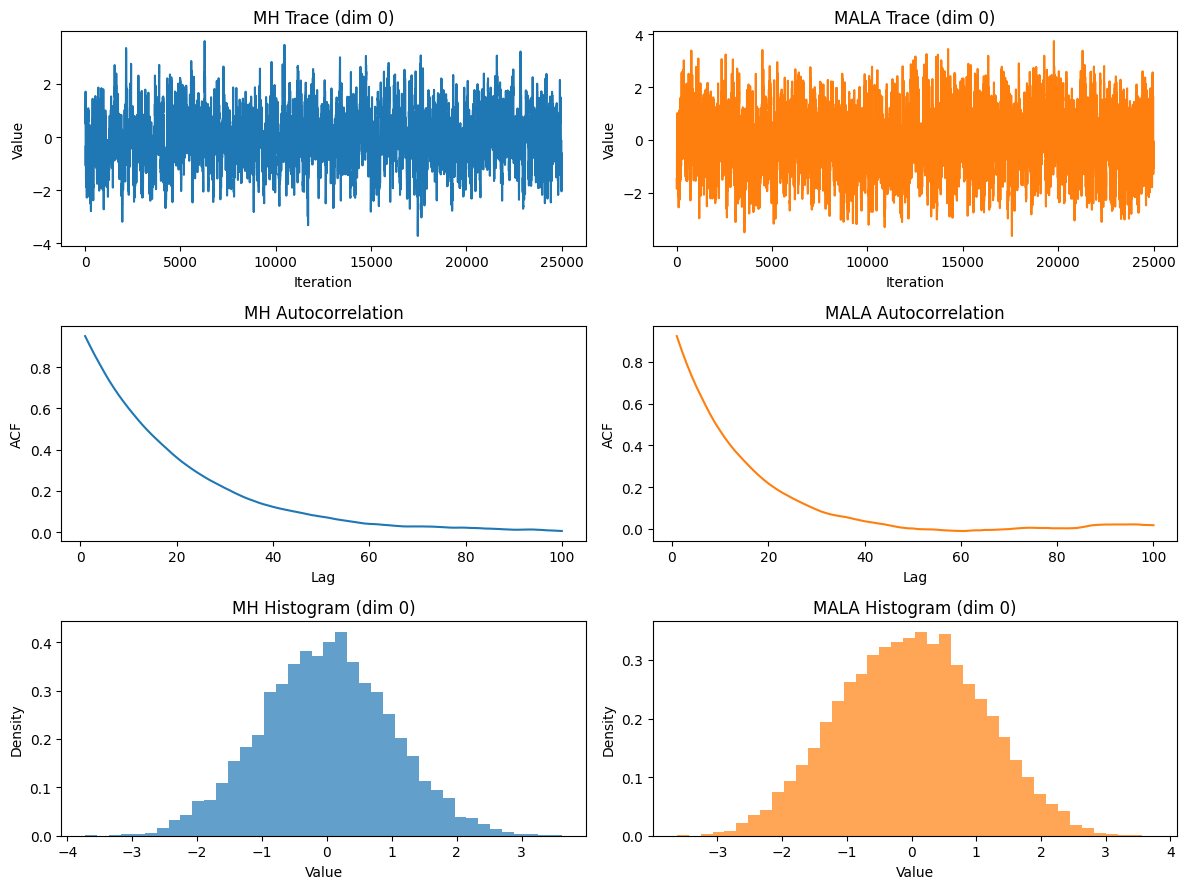

In [17]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

import matplotlib.pyplot as plt

i = 0

def autocorr(x, lag):
    n = len(x)
    x_mean = np.mean(x)
    c0 = np.sum((x - x_mean) ** 2) / n
    if c0 == 0:
        return 0
    return np.sum((x[:n - lag] - x_mean) * (x[lag:] - x_mean)) / (n * c0)

fig, axes = plt.subplots(3, 2, figsize=(12, 9))

axes[0,0].plot(mh_chain_burned[:, i], color='tab:blue')
axes[0,0].set_title("MH Trace (dim 0)")
axes[0,0].set_xlabel("Iteration")
axes[0,0].set_ylabel("Value")

axes[0,1].plot(mala_chain_burned[:, i], color='tab:orange')
axes[0,1].set_title("MALA Trace (dim 0)")
axes[0,1].set_xlabel("Iteration")
axes[0,1].set_ylabel("Value")

max_lag = 100
acf_mh = [autocorr(mh_chain_burned[:, i], lag) for lag in range(1, max_lag+1)]
acf_mala = [autocorr(mala_chain_burned[:, i], lag) for lag in range(1, max_lag+1)]

axes[1,0].plot(range(1, max_lag+1), acf_mh, color='tab:blue')
axes[1,0].set_title("MH Autocorrelation")
axes[1,0].set_xlabel("Lag")
axes[1,0].set_ylabel("ACF")

axes[1,1].plot(range(1, max_lag+1), acf_mala, color='tab:orange')
axes[1,1].set_title("MALA Autocorrelation")
axes[1,1].set_xlabel("Lag")
axes[1,1].set_ylabel("ACF")

axes[2,0].hist(mh_chain_burned[:, i], bins=40, color='tab:blue', alpha=0.7, density=True)
axes[2,0].set_title("MH Histogram (dim 0)")
axes[2,0].set_xlabel("Value")
axes[2,0].set_ylabel("Density")

axes[2,1].hist(mala_chain_burned[:, i], bins=40, color='tab:orange', alpha=0.7, density=True)
axes[2,1].set_title("MALA Histogram (dim 0)")
axes[2,1].set_xlabel("Value")
axes[2,1].set_ylabel("Density")

plt.tight_layout()
plt.show()


**Выводы:** Судя по таблице, MALA показывает значительно более высокий median ESS при почти двукратно большей acceptance rate по сравнению с MH. Это говорит о том, что MALA исследует пространство параметров эффективнее и генерирует более независимые сэмплы, поэтому её можно считать предпочтительным методом.